# Feature Engineering
This notebook apply feature engineering techniques to psd dataframe.

In [2]:
# Setup
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

# upload data
data_dir = '/Users/yeganeh/Codes/otka-preprocessing/docs/data_with_psds.xlsx'
data = pd.read_excel(data_dir, header=1, index_col='Unnamed: 0')
# remove sub 51 & 52
data = data.iloc[:-8]


# Mutual Information

In [3]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [21]:
# feature names
col_names = [i for i in data.columns if data[i].dtype in [np.float64]]
col_names.remove('hypnotizability_total')
# col_names = [i for i in col_names if 'experience' in i]
# col_names = [i for i in col_names if 'diff' in i]

# filter data for those trials when real hypnosis described as hypnosis
data['trial_type'] = data['trial_type'].astype('str') 
data_real = data.query('(trial_type == "True") & (description_type == "hypnosis")')

In [22]:
# data_real.dropna(inplace=True)
data_4MI = data_real[col_names]
X = data_4MI.copy()
y = data_real['hypnosis_depth']

mi_scores = make_mi_scores(X, y)

LC-beta-experience-diff         0.240467
CZ-delta-baseline1              0.236213
RP-beta-baseline2               0.224408
RF-broadband-experience-diff    0.202307
OZ-broadband-baseline1          0.199942
FZ-gamma-experience             0.194729
LO-gamma-baseline1              0.192723
LO-theta-induction-diff         0.181862
RC-delta-experience-diff        0.180007
LC-delta-induction-diff         0.170992
PZ-beta-baseline1               0.164304
LP-theta-experience-diff        0.160727
RP-delta-induction-diff         0.156970
RC-delta-baseline1              0.156596
CZ-alpha-induction-diff         0.156226
LO-beta-induction-diff          0.153832
CZ-beta-induction               0.148416
OZ-beta-baseline2               0.147008
LC-delta-experience-diff        0.143408
LP-delta-experience-diff        0.143367
Name: MI Scores, dtype: float64


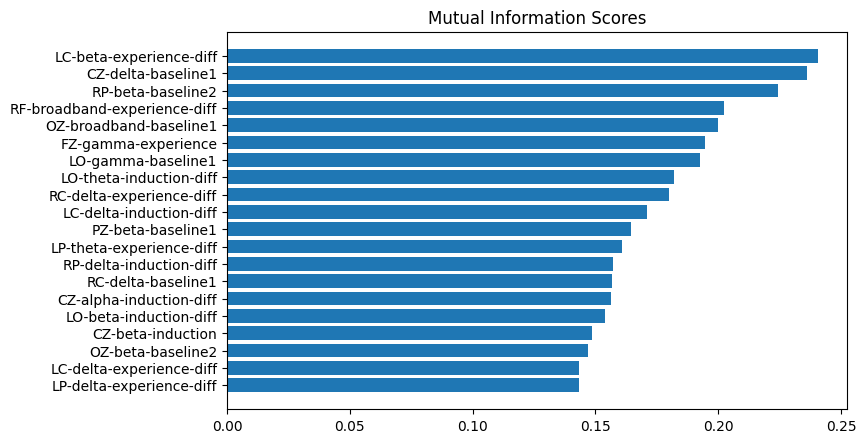

In [23]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20)) 

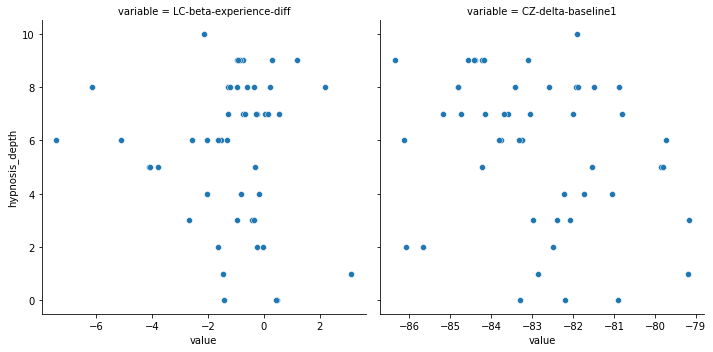

In [26]:
features = mi_scores.index[:2]
sns.relplot(
    x='value', y='hypnosis_depth', col='variable', data=data_real.melt(id_vars='hypnosis_depth',
    value_vars=features), facet_kws=dict(sharex=False),
)

### Discover Interactions

In [ ]:
# create a categorical feature for the hypnotizability level
CatgoricalHypnotizability = data_real.dropna()
CatgoricalHypnotizability['hypnotizability_class'] = CatgoricalHypnotizability['hypnotizability_total'].apply(
    lambda x:'low' if x<=5 else 'high')

In [48]:
CatgoricalHypnotizability['hypnotizability_class'].value_counts()

high    23
low     16
Name: hypnotizability_class, dtype: int64

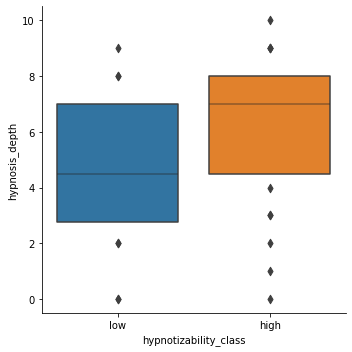

In [50]:
sns.catplot(x="hypnotizability_class", y="hypnosis_depth", data=CatgoricalHypnotizability, kind="boxen");

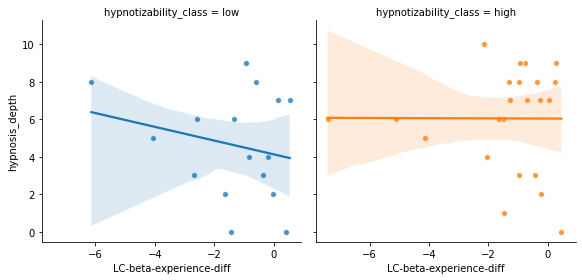

In [51]:
# discover interactions
feature = mi_scores.index[0]

sns.lmplot(
    x=feature, y="hypnosis_depth", hue="hypnotizability_class", col="hypnotizability_class",
    data=CatgoricalHypnotizability, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

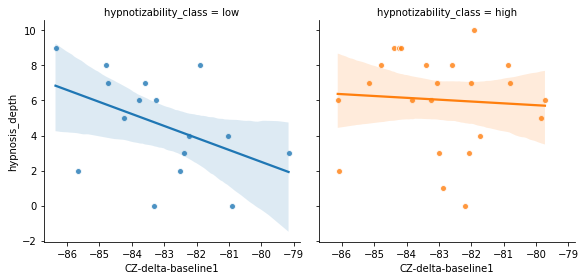

In [52]:
# discover interactions
feature = mi_scores.index[1]

sns.lmplot(
    x=feature, y="hypnosis_depth", hue="hypnotizability_class", col="hypnotizability_class",
    data=CatgoricalHypnotizability, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

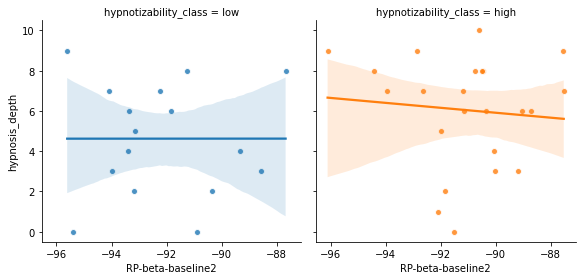

In [56]:
feature = mi_scores.index[2]

sns.lmplot(
    x=feature, y="hypnosis_depth", hue="hypnotizability_class", col="hypnotizability_class",
    data=CatgoricalHypnotizability, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

# Creating Features

In [ ]:
# create new features
col_fast_frontal = [i for i in col_names if (('gamma' in i) or ('beta' in i)) and ('F' in i)]
fw_F = data_real[col_fast_frontal].apply(lambda x:x.mean(), axis=1)

col_gamma_O = [i for i in col_names if (('gamma' in i) or ('beta')) and ('O' in i)]
fw_O = data_real[col_gamma_O].apply(lambda x:x.mean(), axis=1)

col_theta_F = [i for i in col_names if (('theta' in i) or ('alpha' in i) or ('delta' in i)) and ('F' in i)]
sw_F = data_real[col_theta_F].apply(lambda x:x.mean(), axis=1)

col_theta_O = [i for i in col_names if (('theta' in i) or ('alpha' in i) or ('delta' in i)) and ('O' in i)]
sw_O = data_real[col_theta_O].apply(lambda x:x.mean(), axis=1)

# concate new features
data_with_new_features = pd.concat([data_real, fw_F,fw_O,sw_F,sw_O],axis=1) # I should the names the new columns

# todos
1. check the power calculation: Report important filter parameters including filter type, cutoff frequency, filter order (or length, roll-off or transition bandwidth, passband ripple and stopband attenuation, filter delay and causality, direction of computation (Widmann et al., 2015).

2. Calculate other measures: Functional Connectivity, ISC. 

3. check if the FC is standardized


